# Generate Gene List for FunGen xQTL Analysis

## Overview
This analysis is trying to understand the functional pathway signals for the gene list we found from xQTL data. We are trying to answer the question -- we have limit genes overlapped with GVC and TWAS, does that true or we did incorrect analysis. For this, we need to answer it through: 
1. functional pathways enrichment 
    1. for GVC list -- to check the pathways for gold standard
    2. for genes in xQTL data we have -- to check the overview pathways we have;
    3. for specific genes in xQTL data only -- to check the additional pathways we have;
2. PPI analysis -- for the protein level evidence may show the indirect effect
3. Are xQTL-only genes missed by TWAS/GVC because they are tissue-specific/cell type specific? -- need to check the resource of those xQTL-only gene -- or aggregate
4. Identify if xQTL-only genes are regulators or targets in known gene regulatory circuits.
5. The prediction to disease? -- AUC

In [19]:
library(tidyverse)
library(data.table)

### load gene lists

In [20]:
TL1_sig_gene = fread("TL1_gene_list.tsv", sep= '\t')

In [21]:
image_AD1_sig_gene = fread("image_AD1_gene_list.tsv", sep= '\t')
image_AD2_sig_gene = fread("image_AD2_gene_list.tsv", sep= '\t')
image_Aging1_sig_gene = fread("image_Aging1_gene_list.tsv", sep= '\t')
image_Aging2_sig_gene = fread("image_Aging2_gene_list.tsv", sep= '\t')
image_Aging3_sig_gene = fread("image_Aging3_gene_list.tsv", sep= '\t')
image_Aging4_sig_gene = fread("image_Aging4_gene_list.tsv", sep= '\t')
image_Aging5_sig_gene = fread("image_Aging5_gene_list.tsv", sep= '\t')

In [22]:
# Extract gene IDs from each dataset
gene_lists <- list(
  AD1 = image_AD1_sig_gene$gene_id,
  AD2 = image_AD2_sig_gene$gene_id,
  Aging1 = image_Aging1_sig_gene$gene_id,
  Aging2 = image_Aging2_sig_gene$gene_id,
  Aging3 = image_Aging3_sig_gene$gene_id,
  Aging4 = image_Aging4_sig_gene$gene_id,
  Aging5 = image_Aging5_sig_gene$gene_id
)

# Find unique genes for each dataset
unique_genes <- lapply(names(gene_lists), function(name) {
  current_genes <- gene_lists[[name]]
  other_genes <- unique(unlist(gene_lists[names(gene_lists) != name]))
  setdiff(current_genes, other_genes)
})
names(unique_genes) <- paste0("unique_", names(gene_lists), "_genes")

# Summary statistics
sapply(names(unique_genes), function(name) {
  dataset <- gsub("unique_|_genes", "", name)
  total <- length(gene_lists[[dataset]])
  unique_count <- length(unique_genes[[name]])
  cat(sprintf("%s: %d unique / %d total (%.1f%%)\n", 
              name, unique_count, total, unique_count/total*100))
})




unique_AD1_genes: 40 unique / 75 total (53.3%)
unique_AD2_genes: 48 unique / 103 total (46.6%)
unique_Aging1_genes: 113 unique / 150 total (75.3%)
unique_Aging2_genes: 48 unique / 100 total (48.0%)
unique_Aging3_genes: 31 unique / 68 total (45.6%)
unique_Aging4_genes: 34 unique / 59 total (57.6%)
unique_Aging5_genes: 124 unique / 167 total (74.3%)


$unique_AD1_genes
NULL

$unique_AD2_genes
NULL

$unique_Aging1_genes
NULL

$unique_Aging2_genes
NULL

$unique_Aging3_genes
NULL

$unique_Aging4_genes
NULL

$unique_Aging5_genes
NULL

In [24]:
length(unique_genes$unique_AD1_genes)

[1] 40

In [4]:
TL1_AD1_Aging3 = union(intersect(TL1_sig_gene$gene_id, image_Aging3_sig_gene$gene_id), intersect(TL1_sig_gene$gene_id, image_AD1_sig_gene$gene_id)) |> unique()

In [5]:
TL1_AD1 = intersect(TL1_sig_gene$gene_id, image_AD1_sig_gene$gene_id) |> unique()

In [6]:
AD2_Aging4_sig_gene = union(image_AD2_sig_gene$gene_id, image_Aging4_sig_gene$gene_id) |> unique()

In [7]:
AD1_Aging5_sig_gene = union(image_AD1_sig_gene$gene_id, image_Aging5_sig_gene$gene_id)|> unique()

In [8]:
AD2_Aging2_sig_gene = union(image_AD2_sig_gene$gene_id, image_Aging2_sig_gene$gene_id)|> unique()

In [9]:
AD_sig_gene = union(image_AD1_sig_gene$gene_id, image_AD2_sig_gene$gene_id)|> unique()

In [10]:
AD2_Aging2_overlap_sig_gene <- intersect(image_AD2_sig_gene$gene_id,
                                         image_Aging2_sig_gene$gene_id) |> unique()


In [11]:
length(AD2_Aging2_overlap_sig_gene)

[1] 19

In [12]:
dim(TL1_sig_gene)

[1] 1485    5

In [13]:
TL1_sig_gene = unique(TL1_sig_gene)

In [14]:
dim(TL1_sig_gene)

[1] 1485    5

In [15]:
head(TL1_sig_gene)

#chr,start,end,gene_id,gene_name
<chr>,<int>,<int>,<chr>,<chr>
chr10,103268872,105304950,ENSG00000065621,
chr10,99320000,102783413,ENSG00000107833,
chr10,102877569,104918184,ENSG00000107960,
chr10,103309698,105338465,ENSG00000148841,
chr10,3080000,7840000,ENSG00000057608,
chr10,3080000,7840000,ENSG00000108021,


### image_dementia_xQTL list

In [17]:

library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:purrr':

    simplify


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are

In [97]:
TL1_sig_gene_ego <- enrichGO(
  gene          = TL1_sig_gene$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [98]:
head(TL1_sig_gene_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0032200,GO:0032200,telomere organization,36/1155,218/21261,2.272936e-09,1.189655e-05,1.131922e-05,ENSG00000107960/ENSG00000178971/ENSG00000257949/ENSG00000117748/ENSG00000101442/ENSG00000197409/ENSG00000197238/ENSG00000273542/ENSG00000128513/ENSG00000149311/ENSG00000169592/ENSG00000132383/ENSG00000118655/ENSG00000143799/ENSG00000258366/ENSG00000145414/ENSG00000133302/ENSG00000278705/ENSG00000286522/ENSG00000287080/ENSG00000276966/ENSG00000273983/ENSG00000278828/ENSG00000197153/ENSG00000275126/ENSG00000275379/ENSG00000204569/ENSG00000147601/ENSG00000102977/ENSG00000070366/ENSG00000163029/ENSG00000163806/ENSG00000164362/ENSG00000165392/ENSG00000253729/ENSG00000132604,36
GO:0034502,GO:0034502,protein localization to chromosome,25/1155,127/21261,1.786214e-08,4.204367e-05,4.000334e-05,ENSG00000184445/ENSG00000117748/ENSG00000197238/ENSG00000273542/ENSG00000161036/ENSG00000128513/ENSG00000132383/ENSG00000143799/ENSG00000133302/ENSG00000278705/ENSG00000278463/ENSG00000276966/ENSG00000124635/ENSG00000275126/ENSG00000164808/ENSG00000147601/ENSG00000066336/ENSG00000102977/ENSG00000163806/ENSG00000063978/ENSG00000164362/ENSG00000031691/ENSG00000176476/ENSG00000132604/ENSG00000181555,25
GO:0006334,GO:0006334,nucleosome assembly,26/1155,138/21261,2.409840e-08,4.204367e-05,4.000334e-05,ENSG00000167670/ENSG00000124610/ENSG00000180596/ENSG00000187837/ENSG00000197409/ENSG00000197238/ENSG00000233822/ENSG00000273542/ENSG00000278705/ENSG00000286522/ENSG00000276410/ENSG00000287080/ENSG00000273802/ENSG00000274290/ENSG00000276966/ENSG00000273983/ENSG00000124635/ENSG00000185130/ENSG00000278828/ENSG00000197153/ENSG00000274641/ENSG00000275126/ENSG00000275379/ENSG00000180543/ENSG00000178021/ENSG00000204256,26
GO:0034728,GO:0034728,nucleosome organization,28/1155,160/21261,3.763414e-08,4.924427e-05,4.685450e-05,ENSG00000167670/ENSG00000124610/ENSG00000180596/ENSG00000187837/ENSG00000197409/ENSG00000197238/ENSG00000233822/ENSG00000273542/ENSG00000278705/ENSG00000286522/ENSG00000276410/ENSG00000287080/ENSG00000273802/ENSG00000274290/ENSG00000276966/ENSG00000273983/ENSG00000124635/ENSG00000185130/ENSG00000278828/ENSG00000197153/ENSG00000274641/ENSG00000275126/ENSG00000275379/ENSG00000180543/ENSG00000178021/ENSG00000204256/ENSG00000181555/ENSG00000189308,28
GO:0016233,GO:0016233,telomere capping,13/1155,42/21261,1.956355e-07,2.047912e-04,1.948529e-04,ENSG00000107960/ENSG00000178971/ENSG00000257949/ENSG00000128513/ENSG00000149311/ENSG00000118655/ENSG00000258366/ENSG00000147601/ENSG00000102977/ENSG00000070366/ENSG00000163806/ENSG00000253729/ENSG00000132604,13


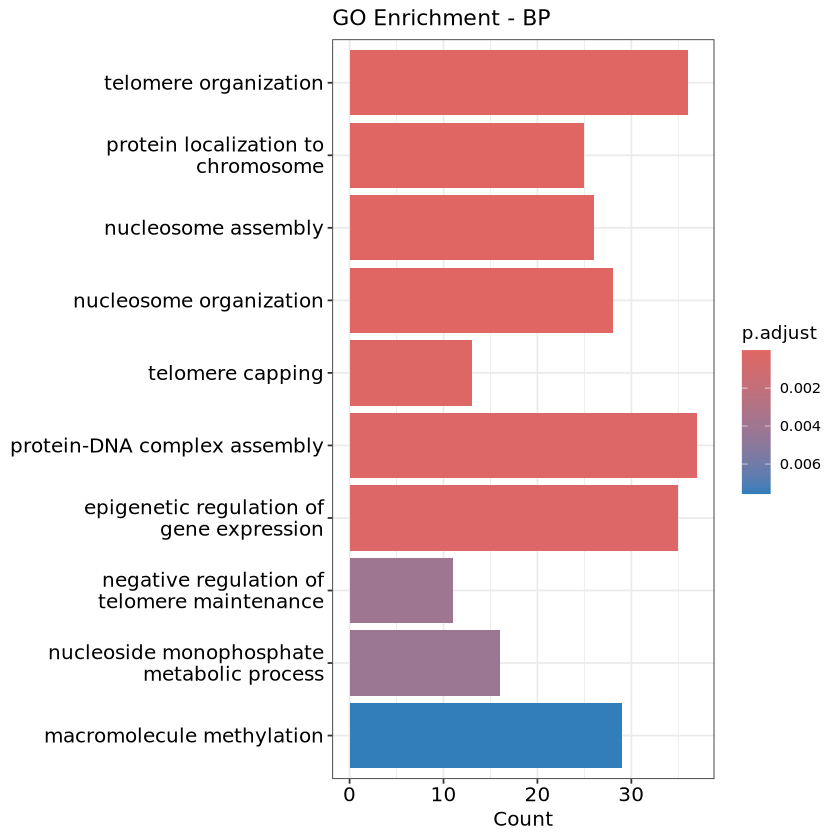

In [99]:
barplot(TL1_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [100]:
TL1_sig_gene_ego |> as.data.frame() |> filter(str_detect(Description, "cilium|microtubule|vesicle|tubulin"))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0046785,GO:0046785,microtubule polymerization,15/1155,110/21261,0.0008905418,0.08421020,0.08012358,ENSG00000108961/ENSG00000101639/ENSG00000159713/ENSG00000131351/ENSG00000078018/ENSG00000214367/ENSG00000204389/ENSG00000175216/ENSG00000130779/ENSG00000047849/ENSG00000171368/ENSG00000204388/ENSG00000111276/ENSG00000128159/ENSG00000072864,15
GO:0007020,GO:0007020,microtubule nucleation,10/1155,57/21261,0.0009009880,0.08421020,0.08012358,ENSG00000108961/ENSG00000101639/ENSG00000131351/ENSG00000214367/ENSG00000204389/ENSG00000175216/ENSG00000171368/ENSG00000204388/ENSG00000128159/ENSG00000072864,10
GO:0006900,GO:0006900,vesicle budding from membrane,13/1155,89/21261,0.0010072820,0.08947217,0.08513019,ENSG00000132612/ENSG00000163558/ENSG00000249915/ENSG00000113615/ENSG00000254505/ENSG00000166747/ENSG00000256060/ENSG00000143457/ENSG00000137942/ENSG00000106299/ENSG00000086598/ENSG00000086065/ENSG00000138674,13
GO:0048193,GO:0048193,Golgi vesicle transport,31/1155,326/21261,0.0018213094,0.11625284,0.11061123,ENSG00000177951/ENSG00000092531/ENSG00000188603/ENSG00000131899/ENSG00000108961/ENSG00000101246/ENSG00000213380/ENSG00000125991/ENSG00000184432/ENSG00000163558/ENSG00000249915/ENSG00000113615/ENSG00000223501/ENSG00000231925/ENSG00000111481/ENSG00000125149/ENSG00000103051/ENSG00000166747/ENSG00000220205/ENSG00000256060/ENSG00000143457/ENSG00000127603/ENSG00000181789/ENSG00000132405/ENSG00000004059/ENSG00000086598/ENSG00000073969/ENSG00000029725/ENSG00000105669/ENSG00000221838/ENSG00000138674,31
GO:0010968,GO:0010968,regulation of microtubule nucleation,6/1155,27/21261,0.0028043694,0.15525357,0.14771929,ENSG00000108961/ENSG00000131351/ENSG00000214367/ENSG00000204389/ENSG00000175216/ENSG00000204388,6
GO:0031109,GO:0031109,microtubule polymerization or depolymerization,17/1155,152/21261,0.0037564741,0.17873987,0.17006583,ENSG00000108961/ENSG00000101639/ENSG00000197457/ENSG00000159713/ENSG00000131351/ENSG00000078018/ENSG00000214367/ENSG00000204389/ENSG00000175216/ENSG00000130779/ENSG00000128881/ENSG00000047849/ENSG00000171368/ENSG00000204388/ENSG00000111276/ENSG00000128159/ENSG00000072864,17
GO:0006891,GO:0006891,intra-Golgi vesicle-mediated transport,7/1155,38/21261,0.0039348441,0.18269160,0.17382579,ENSG00000213380/ENSG00000184432/ENSG00000111481/ENSG00000103051/ENSG00000181789/ENSG00000073969/ENSG00000105669,7
GO:0006890,GO:0006890,"retrograde vesicle-mediated transport, Golgi to endoplasmic reticulum",9/1155,59/21261,0.0043230630,0.19175349,0.18244791,ENSG00000177951/ENSG00000125991/ENSG00000184432/ENSG00000231925/ENSG00000111481/ENSG00000103051/ENSG00000143457/ENSG00000004059/ENSG00000105669,9
GO:0070507,GO:0070507,regulation of microtubule cytoskeleton organization,19/1155,182/21261,0.0048753243,0.20634751,0.19633370,ENSG00000108961/ENSG00000197457/ENSG00000131351/ENSG00000078018/ENSG00000114107/ENSG00000214367/ENSG00000137343/ENSG00000204389/ENSG00000175216/ENSG00000130779/ENSG00000136122/ENSG00000254505/ENSG00000128881/ENSG00000063978/ENSG00000171368/ENSG00000204388/ENSG00000111276/ENSG00000083799/ENSG00000086065,19


In [16]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/TL1_GO_BP.png', width = 6, height = 6)

In [101]:
TL1_sig_gene_ego_cc <- enrichGO(
  gene          = TL1_sig_gene$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [102]:
head(TL1_sig_gene_ego_cc, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000781,GO:0000781,"chromosome, telomeric region",38/1210,199/22568,6.777847e-12,4.459823e-09,4.031035e-09,ENSG00000107960/ENSG00000178971/ENSG00000257949/ENSG00000117748/ENSG00000213639/ENSG00000197238/ENSG00000273542/ENSG00000161036/ENSG00000128513/ENSG00000104738/ENSG00000149311/ENSG00000131652/ENSG00000132383/ENSG00000118655/ENSG00000143799/ENSG00000258366/ENSG00000100242/ENSG00000133302/ENSG00000278705/ENSG00000276410/ENSG00000276966/ENSG00000275126/ENSG00000204569/ENSG00000147601/ENSG00000092203/ENSG00000102977/ENSG00000070366/ENSG00000101596/ENSG00000183765/ENSG00000076003/ENSG00000163029/ENSG00000163806/ENSG00000164091/ENSG00000164362/ENSG00000165392/ENSG00000253729/ENSG00000094916/ENSG00000132604,38
GO:0098687,GO:0098687,chromosomal region,60/1210,444/22568,4.096088e-11,1.347613e-08,1.218047e-08,ENSG00000107960/ENSG00000119969/ENSG00000088986/ENSG00000184445/ENSG00000178971/ENSG00000257949/ENSG00000117748/ENSG00000213639/ENSG00000197238/ENSG00000273542/ENSG00000161036/ENSG00000128513/ENSG00000066923/ENSG00000104738/ENSG00000149311/ENSG00000080815/ENSG00000131652/ENSG00000153774/ENSG00000132383/ENSG00000118655/ENSG00000143799/ENSG00000184402/ENSG00000258366/ENSG00000100242/ENSG00000133302/ENSG00000278705/ENSG00000276410/ENSG00000278463/ENSG00000276966/ENSG00000124635/ENSG00000275126/ENSG00000204569/ENSG00000147601/ENSG00000110713/ENSG00000175216/ENSG00000130779/ENSG00000092203/ENSG00000254505/ENSG00000102977/ENSG00000167513/ENSG00000070366/ENSG00000085415/ENSG00000101596/ENSG00000105146/ENSG00000183765/ENSG00000076003/ENSG00000163029/ENSG00000163806/ENSG00000113810/ENSG00000164091/ENSG00000164362/ENSG00000031691/ENSG00000165392/ENSG00000253729/ENSG00000030066/ENSG00000094916/ENSG00000132604/ENSG00000086065/ENSG00000197724/ENSG00000072864,60
GO:0000786,GO:0000786,nucleosome,28/1210,137/22568,7.791344e-10,1.708902e-07,1.544600e-07,ENSG00000124610/ENSG00000180596/ENSG00000187837/ENSG00000197409/ENSG00000197238/ENSG00000233822/ENSG00000273542/ENSG00000120616/ENSG00000198959/ENSG00000133302/ENSG00000278705/ENSG00000286522/ENSG00000276410/ENSG00000278463/ENSG00000287080/ENSG00000273802/ENSG00000274290/ENSG00000276966/ENSG00000273983/ENSG00000124635/ENSG00000185130/ENSG00000196747/ENSG00000197903/ENSG00000278828/ENSG00000197153/ENSG00000274641/ENSG00000275126/ENSG00000275379,28
GO:0000782,GO:0000782,telomere cap complex,8/1210,13/22568,6.747698e-08,8.879971e-06,8.026210e-06,ENSG00000107960/ENSG00000178971/ENSG00000257949/ENSG00000128513/ENSG00000147601/ENSG00000102977/ENSG00000164362/ENSG00000132604,8
GO:0000783,GO:0000783,nuclear telomere cap complex,8/1210,13/22568,6.747698e-08,8.879971e-06,8.026210e-06,ENSG00000107960/ENSG00000178971/ENSG00000257949/ENSG00000128513/ENSG00000147601/ENSG00000102977/ENSG00000164362/ENSG00000132604,8


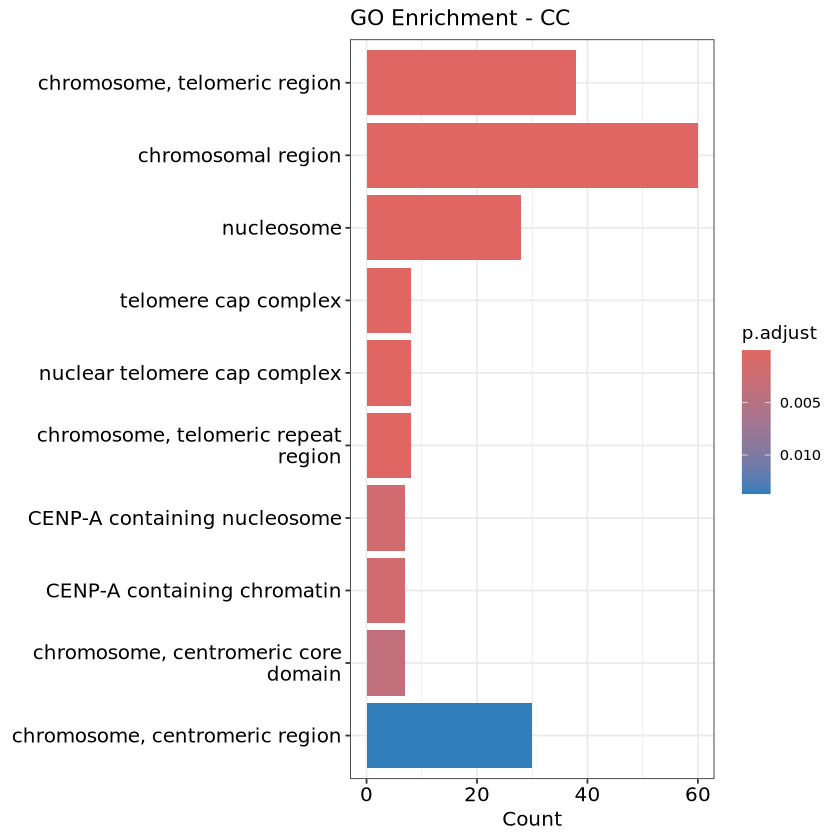

In [103]:
barplot(TL1_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [24]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/TL1_GO_CC.png', width = 6, height = 6)

In [104]:
TL1_sig_gene_ego_mf <- enrichGO(
  gene          = TL1_sig_gene$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [105]:
head(TL1_sig_gene_ego_mf, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030527,GO:0030527,structural constituent of chromatin,25/1197,101/21059,2.864842e-10,2.839059e-07,2.771358e-07,ENSG00000124610/ENSG00000180596/ENSG00000187837/ENSG00000197409/ENSG00000197238/ENSG00000233822/ENSG00000273542/ENSG00000278705/ENSG00000286522/ENSG00000276410/ENSG00000278463/ENSG00000287080/ENSG00000273802/ENSG00000274290/ENSG00000276966/ENSG00000273983/ENSG00000124635/ENSG00000185130/ENSG00000196747/ENSG00000197903/ENSG00000278828/ENSG00000197153/ENSG00000274641/ENSG00000275126/ENSG00000275379,25
GO:0042162,GO:0042162,telomeric DNA binding,13/1197,40/21059,1.726355e-07,8.554091e-05,8.350109e-05,ENSG00000107960/ENSG00000178971/ENSG00000257949/ENSG00000117748/ENSG00000128513/ENSG00000132383/ENSG00000147601/ENSG00000169062/ENSG00000102977/ENSG00000070366/ENSG00000164362/ENSG00000165392/ENSG00000132604,13
GO:0043047,GO:0043047,single-stranded telomeric DNA binding,7/1197,12/21059,1.159175e-06,3.829141e-04,3.737831e-04,ENSG00000107960/ENSG00000178971/ENSG00000117748/ENSG00000128513/ENSG00000132383/ENSG00000147601/ENSG00000132604,7
GO:0098505,GO:0098505,G-rich strand telomeric DNA binding,6/1197,10/21059,5.738608e-06,1.421740e-03,1.387837e-03,ENSG00000178971/ENSG00000117748/ENSG00000128513/ENSG00000132383/ENSG00000147601/ENSG00000132604,6
GO:0098847,GO:0098847,sequence-specific single stranded DNA binding,7/1197,15/21059,8.094857e-06,1.604401e-03,1.566142e-03,ENSG00000107960/ENSG00000178971/ENSG00000117748/ENSG00000128513/ENSG00000132383/ENSG00000147601/ENSG00000132604,7


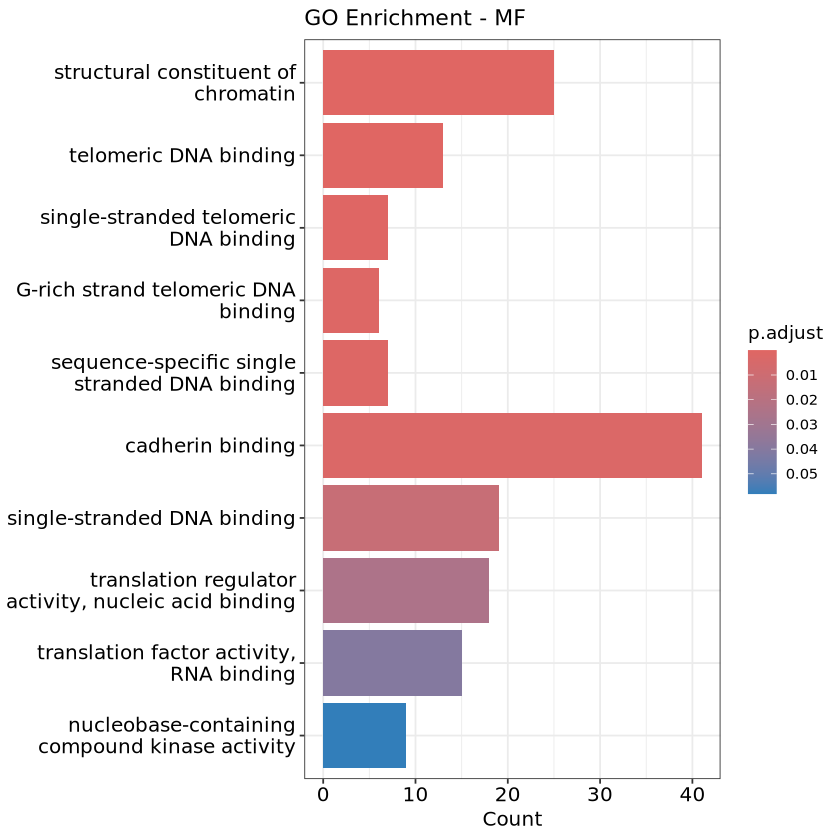

In [106]:
barplot(TL1_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [28]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/TL1_GO_MF.png', width = 6, height = 6)

### image_AD1_xQTL list

In [34]:
AD1_sig_gene_ego <- enrichGO(
  gene          = unique_genes$unique_AD1_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [35]:
head(AD1_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006282,GO:0006282,regulation of DNA repair,5/37,236/21261,5.268931e-05,0.05906472,0.04703214,ENSG00000100811/ENSG00000181555/ENSG00000173473/ENSG00000146648/ENSG00000105229,5
GO:0045739,GO:0045739,positive regulation of DNA repair,4/37,142/21261,1.061373e-04,0.05948998,0.04737077,ENSG00000100811/ENSG00000173473/ENSG00000146648/ENSG00000105229,4
GO:1905634,GO:1905634,regulation of protein localization to chromatin,2/37,11/21261,1.604831e-04,0.05996719,0.04775076,ENSG00000181555/ENSG00000105229,2
GO:0046718,GO:0046718,viral entry into host cell,4/37,202/21261,4.086434e-04,0.10608258,0.08447160,ENSG00000171206/ENSG00000100097/ENSG00000164733/ENSG00000146648,4
GO:0044409,GO:0044409,entry into host,4/37,210/21261,4.731605e-04,0.10608258,0.08447160,ENSG00000171206/ENSG00000100097/ENSG00000164733/ENSG00000146648,4
GO:0044403,GO:0044403,biological process involved in symbiotic interaction,5/37,398/21261,5.967114e-04,0.11148558,0.08877391,ENSG00000171206/ENSG00000100097/ENSG00000164733/ENSG00000146648/ENSG00000241973,5
GO:0044000,GO:0044000,movement in host,4/37,236/21261,7.331191e-04,0.11740378,0.09348646,ENSG00000171206/ENSG00000100097/ENSG00000164733/ENSG00000146648,4
GO:0051701,GO:0051701,biological process involved in interaction with host,4/37,266/21261,1.143352e-03,0.16021223,0.12757403,ENSG00000171206/ENSG00000100097/ENSG00000164733/ENSG00000146648,4
GO:0034502,GO:0034502,protein localization to chromosome,3/37,127/21261,1.394288e-03,0.17073897,0.13595628,ENSG00000181555/ENSG00000258724/ENSG00000105229,3


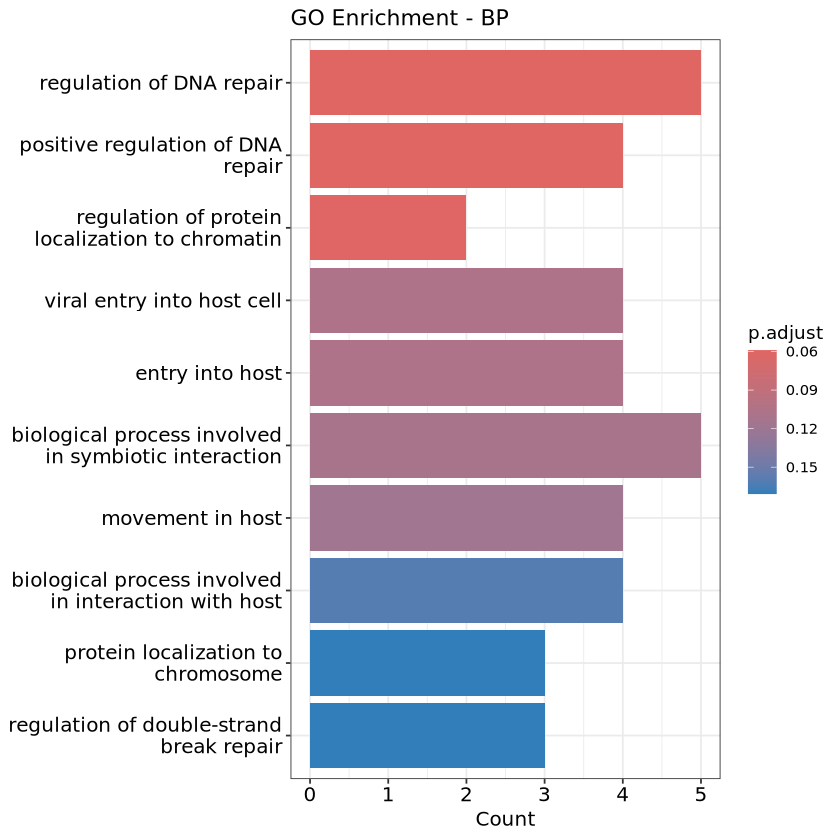

In [36]:
barplot(AD1_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [105]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_AD1_GO_BP.png', width = 6, height = 6)

In [37]:
AD1_sig_gene_ego_cc <- enrichGO(
  gene          = unique_genes$unique_AD1_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [38]:
head(AD1_sig_gene_ego_cc, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005875,GO:0005875,microtubule associated complex,4/39,165/22568,0.0001856117,0.02394391,0.01856117,ENSG00000088727/ENSG00000047849/ENSG00000137177/ENSG00000138107,4
GO:0016363,GO:0016363,nuclear matrix,3/39,134/22568,0.0015999097,0.07102444,0.05505770,ENSG00000100811/ENSG00000173473/ENSG00000105229,3
GO:1904813,GO:1904813,ficolin-1-rich granule lumen,3/39,150/22568,0.0022071853,0.07102444,0.05505770,ENSG00000178035/ENSG00000164733/ENSG00000167658,3
GO:0034399,GO:0034399,nuclear periphery,3/39,159/22568,0.0026037957,0.07102444,0.05505770,ENSG00000100811/ENSG00000173473/ENSG00000105229,3
GO:0005871,GO:0005871,kinesin complex,2/39,52/22568,0.0036537300,0.07102444,0.05505770,ENSG00000088727/ENSG00000137177,2


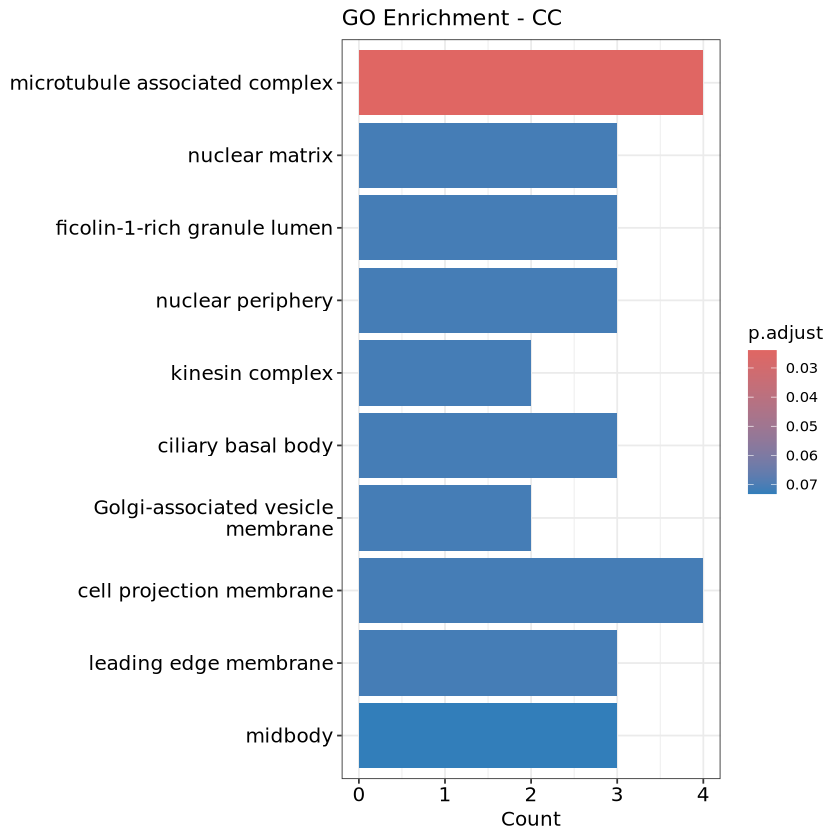

In [39]:
barplot(AD1_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [109]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_AD1_GO_CC.png', width = 6, height = 6)

In [40]:
image_AD1_sig_gene_ego_mf <- enrichGO(
  gene          = unique_genes$unique_AD1_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [41]:
head(image_AD1_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015631,GO:0015631,tubulin binding,4/39,397/21059,0.006078825,0.2147975,0.1821383,ENSG00000088727/ENSG00000181555/ENSG00000047849/ENSG00000137177,4
GO:0003777,GO:0003777,microtubule motor activity,2/39,75/21059,0.008516217,0.2147975,0.1821383,ENSG00000088727/ENSG00000137177,2
GO:0008017,GO:0008017,microtubule binding,3/39,289/21059,0.016240916,0.2147975,0.1821383,ENSG00000088727/ENSG00000047849/ENSG00000137177,3
GO:0016671,GO:0016671,"oxidoreductase activity, acting on a sulfur group of donors, disulfide as acceptor",1/39,10/21059,0.018369715,0.2147975,0.1821383,ENSG00000175806,1
GO:0035256,GO:0035256,G protein-coupled glutamate receptor binding,1/39,10/21059,0.018369715,0.2147975,0.1821383,ENSG00000128271,1
GO:0003774,GO:0003774,cytoskeletal motor activity,2/39,121/21059,0.021123161,0.2147975,0.1821383,ENSG00000088727/ENSG00000137177,2
GO:0017154,GO:0017154,semaphorin receptor activity,1/39,12/21059,0.022003999,0.2147975,0.1821383,ENSG00000164050,1
GO:0043022,GO:0043022,ribosome binding,2/39,127/21059,0.023118242,0.2147975,0.1821383,ENSG00000104626/ENSG00000167658,2
GO:0030295,GO:0030295,protein kinase activator activity,2/39,133/21059,0.025188163,0.2147975,0.1821383,ENSG00000073417/ENSG00000146648,2


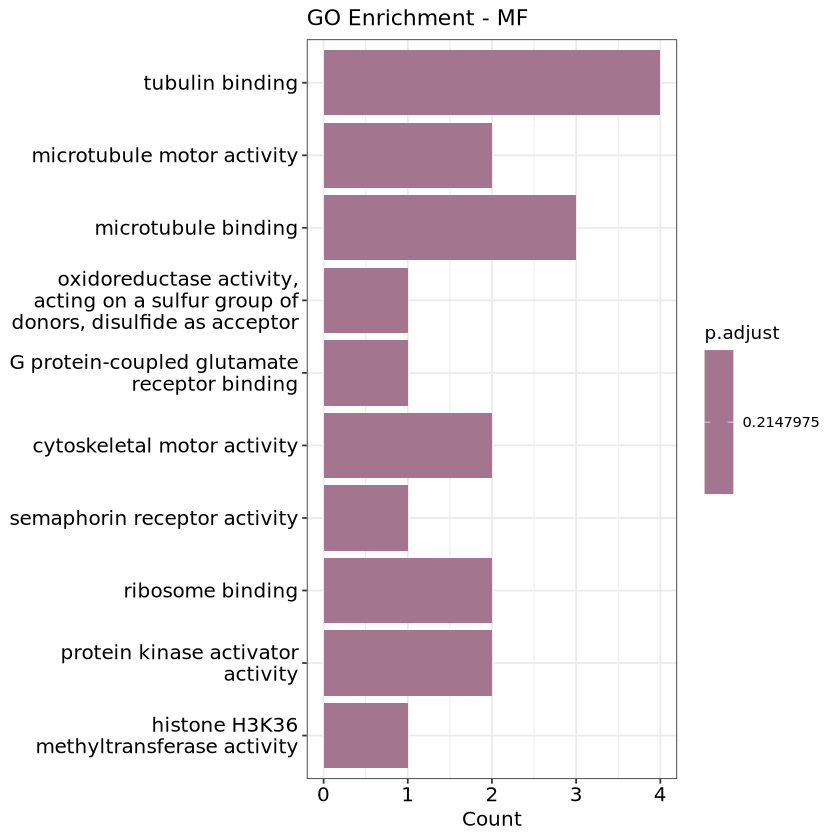

In [42]:
barplot(image_AD1_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [113]:
## ALR4C,GAN12(vascular), ARL3, EEF2; MAP4, KIF13A, ADORA2A(vascular), KDM2B

In [114]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_AD1_GO_MF.png', width = 6, height = 6)

### image_AD2_xQTL list

In [43]:
AD2_xQTL_ego <- enrichGO(
  gene          = unique_genes$unique_AD2_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [44]:
head(AD2_xQTL_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007020,GO:0007020,microtubule nucleation,3/44,57/21261,0.0002238003,0.1909098,0.1662468,ENSG00000037042/ENSG00000175216/ENSG00000176155,3
GO:0033147,GO:0033147,negative regulation of intracellular estrogen receptor signaling pathway,2/44,16/21261,0.0004931157,0.1909098,0.1662468,ENSG00000012048/ENSG00000144580,2
GO:0051298,GO:0051298,centrosome duplication,3/44,82/21261,0.0006533864,0.1909098,0.1662468,ENSG00000012048/ENSG00000175216/ENSG00000176155,3
GO:0006497,GO:0006497,protein lipidation,3/44,96/21261,0.0010331145,0.1909098,0.1662468,ENSG00000136448/ENSG00000175224/ENSG00000156599,3
GO:0042158,GO:0042158,lipoprotein biosynthetic process,3/44,103/21261,0.0012659301,0.1909098,0.1662468,ENSG00000136448/ENSG00000175224/ENSG00000156599,3


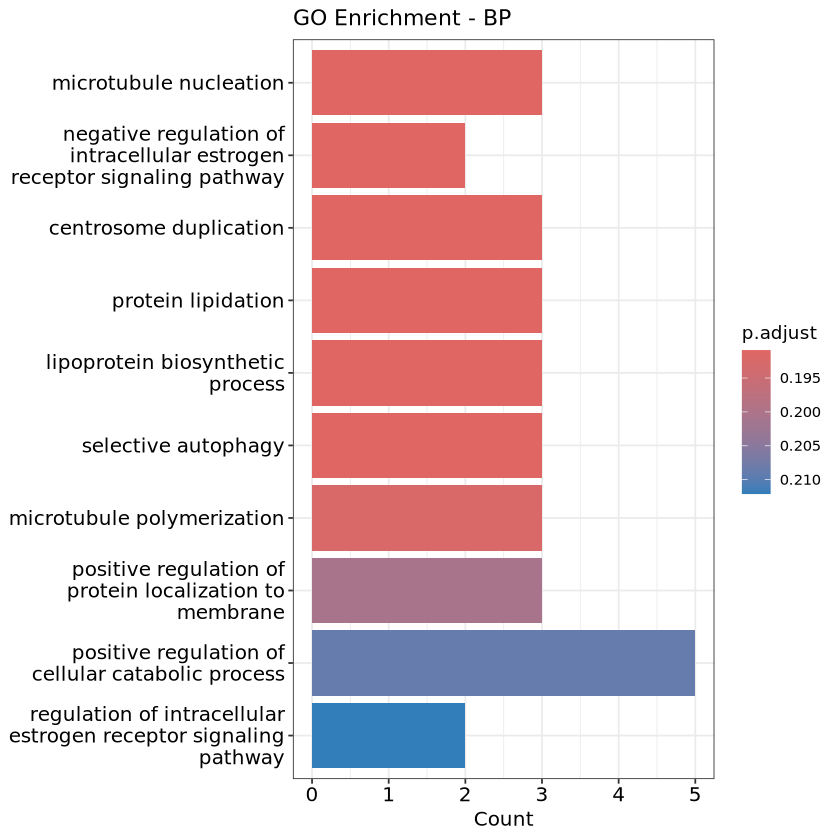

In [45]:
barplot(AD2_xQTL_ego, showCategory = 10, title = "GO Enrichment - BP")

In [118]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_AD2_GO_BP.png', width = 6, height = 6)

In [46]:
AD2_xQTL_ego_cc <- enrichGO(
  gene          = unique_genes$unique_AD2_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [47]:
head(AD2_xQTL_ego_cc, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000930,GO:0000930,gamma-tubulin complex,2/45,20/22568,0.0007219806,0.04043092,0.03229913,ENSG00000012048/ENSG00000037042,2
GO:0099091,GO:0099091,"postsynaptic specialization, intracellular component",2/45,20/22568,0.0007219806,0.04043092,0.03229913,ENSG00000156599/ENSG00000198561,2
GO:0098978,GO:0098978,glutamatergic synapse,4/45,440/22568,0.0113086370,0.19553077,0.15620409,ENSG00000131094/ENSG00000118407/ENSG00000156599/ENSG00000198561,4
GO:0005876,GO:0005876,spindle microtubule,2/45,83/22568,0.0119418558,0.19553077,0.15620409,ENSG00000037042/ENSG00000176155,2
GO:0000931,GO:0000931,gamma-tubulin ring complex,1/45,10/22568,0.0197656750,0.19553077,0.15620409,ENSG00000012048,1
GO:1990229,GO:1990229,iron-sulfur cluster assembly complex,1/45,12/22568,0.0236727167,0.19553077,0.15620409,ENSG00000244005,1
GO:0035770,GO:0035770,ribonucleoprotein granule,3/45,312/22568,0.0242197603,0.19553077,0.15620409,ENSG00000144580/ENSG00000144535/ENSG00000136270,3
GO:0000932,GO:0000932,P-body,2/45,123/22568,0.0250408444,0.19553077,0.15620409,ENSG00000144580/ENSG00000144535,2
GO:0031209,GO:0031209,SCAR complex,1/45,14/22568,0.0275645304,0.19553077,0.15620409,ENSG00000055163,1


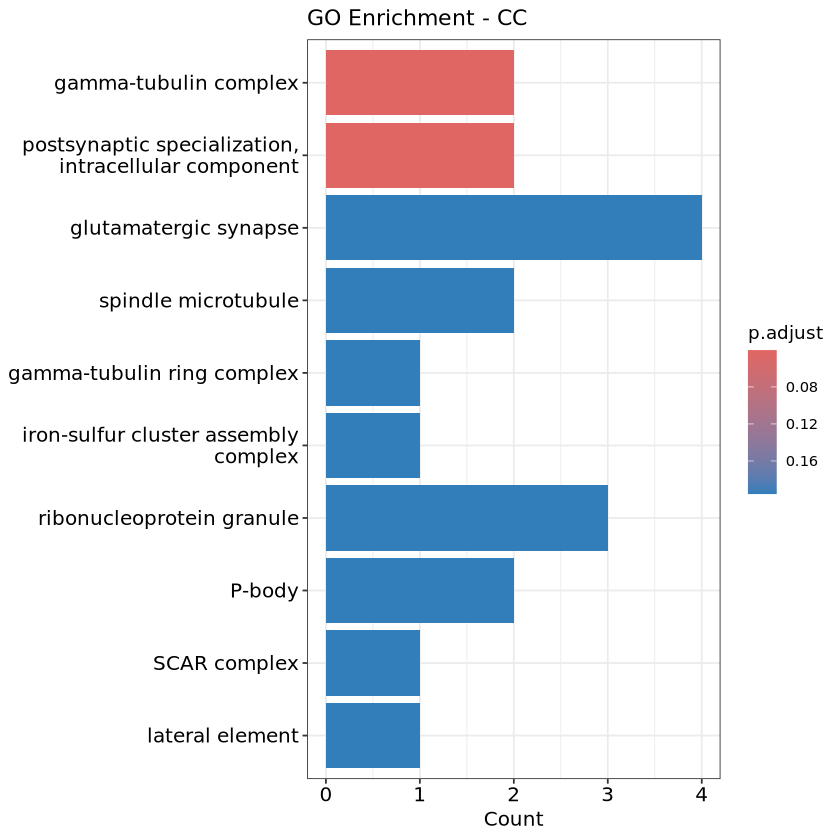

In [48]:
barplot(AD2_xQTL_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [122]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_AD2_GO_CC.png', width = 6, height = 6)

In [49]:
AD2_xQTL_ego_mf <- enrichGO(
  gene          = unique_genes$unique_AD2_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [50]:
head(AD2_xQTL_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016783,GO:0016783,sulfurtransferase activity,1/43,11/21059,0.02223802,0.2889349,0.2708765,ENSG00000244005,1
GO:0019107,GO:0019107,myristoyltransferase activity,1/43,11/21059,0.02223802,0.2889349,0.2708765,ENSG00000136448,1
GO:0019203,GO:0019203,carbohydrate phosphatase activity,1/43,11/21059,0.02223802,0.2889349,0.2708765,ENSG00000141349,1
GO:0019855,GO:0019855,calcium channel inhibitor activity,1/43,11/21059,0.02223802,0.2889349,0.2708765,ENSG00000165912,1
GO:0050308,GO:0050308,sugar-phosphatase activity,1/43,11/21059,0.02223802,0.2889349,0.2708765,ENSG00000141349,1
GO:0004143,GO:0004143,ATP-dependent diacylglycerol kinase activity,1/43,12/21059,0.02423554,0.2889349,0.2708765,ENSG00000149091,1
GO:0016423,GO:0016423,tRNA (guanine) methyltransferase activity,1/43,12/21059,0.02423554,0.2889349,0.2708765,ENSG00000066651,1
GO:0004861,GO:0004861,cyclin-dependent protein serine/threonine kinase inhibitor activity,1/43,13/21059,0.02622907,0.2889349,0.2708765,ENSG00000186834,1
GO:1990782,GO:1990782,protein tyrosine kinase binding,2/43,136/21059,0.03146068,0.2889349,0.2708765,ENSG00000134569/ENSG00000198561,2


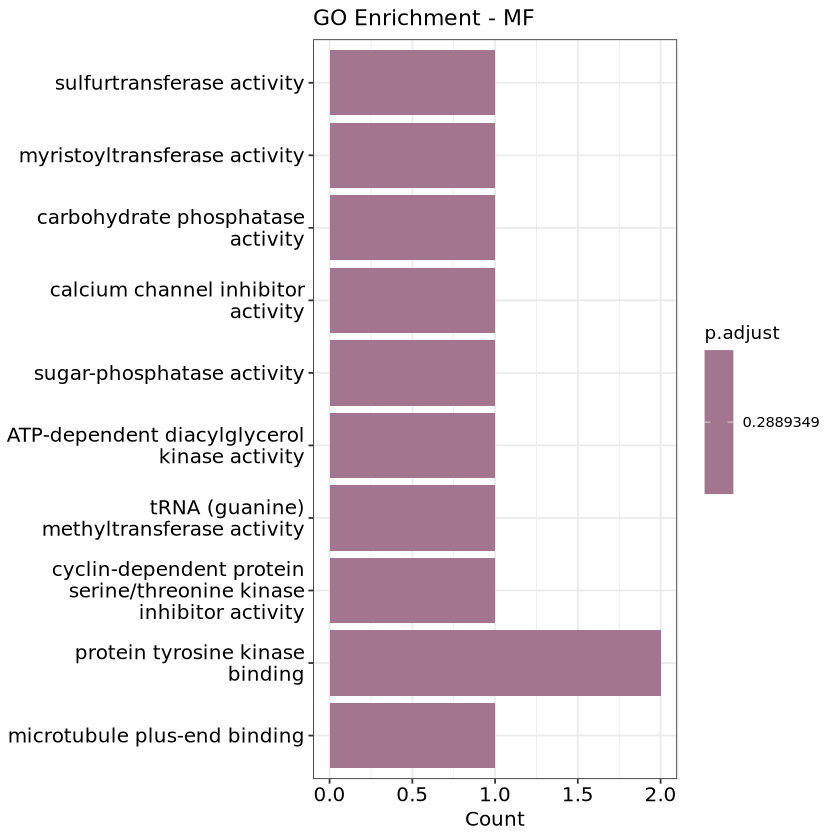

In [51]:
barplot(AD2_xQTL_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [126]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_AD2_GO_MF.png', width = 6, height = 6)

### image_Aging1_xQTL list

In [52]:
Aging1_xQTL_ego <- enrichGO(
  gene          = unique_genes$unique_Aging1_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [53]:
head(Aging1_xQTL_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006970,GO:0006970,response to osmotic stress,4/101,89/21261,0.0008596282,0.3032028,0.298614,ENSG00000188603/ENSG00000166925/ENSG00000102908/ENSG00000088836,4
GO:1904869,GO:1904869,regulation of protein localization to Cajal body,2/101,12/21261,0.0014296707,0.3032028,0.298614,ENSG00000146834/ENSG00000120438,2
GO:1904871,GO:1904871,positive regulation of protein localization to Cajal body,2/101,12/21261,0.0014296707,0.3032028,0.298614,ENSG00000146834/ENSG00000120438,2
GO:0006814,GO:0006814,sodium ion transport,6/101,259/21261,0.0014887654,0.3032028,0.298614,ENSG00000158865/ENSG00000135740/ENSG00000168575/ENSG00000066230/ENSG00000018236/ENSG00000088836,6
GO:0006068,GO:0006068,ethanol catabolic process,2/101,13/21261,0.0016843840,0.3032028,0.298614,ENSG00000196502/ENSG00000197165,2


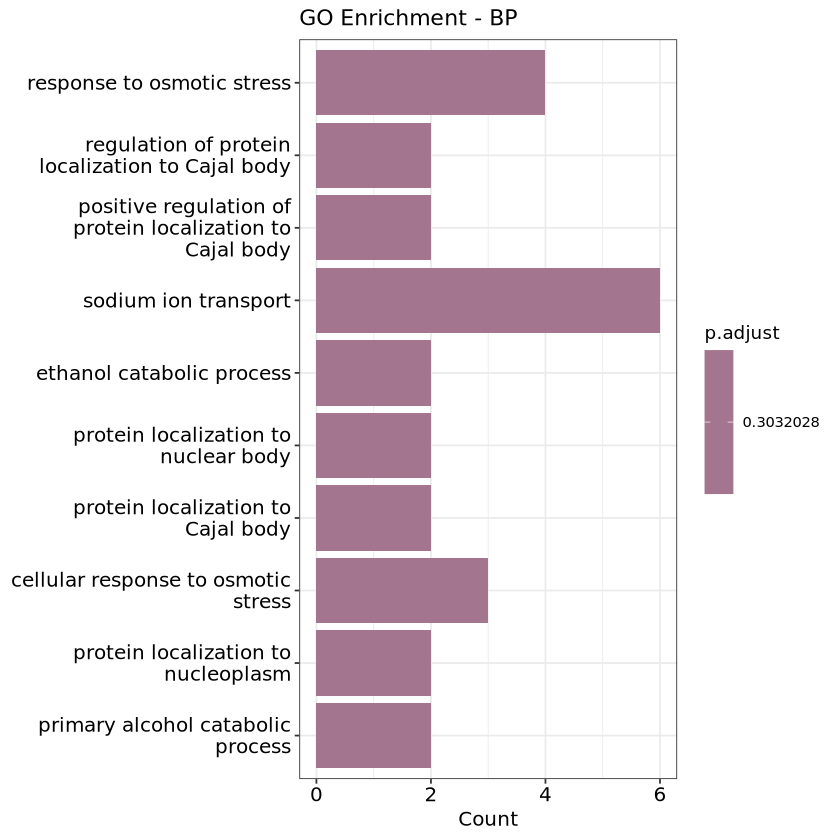

In [54]:
barplot(Aging1_xQTL_ego, showCategory = 10, title = "GO Enrichment - BP")

In [130]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging1_GO_BP.png', width = 6, height = 6)

In [55]:
Aging1_xQTL_ego_cc <- enrichGO(
  gene          = unique_genes$unique_Aging1_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [56]:
head(Aging1_xQTL_ego_cc, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0034358,GO:0034358,plasma lipoprotein particle,4/103,44/22568,4.827204e-05,0.005146549,0.004822825,ENSG00000184730/ENSG00000204444/ENSG00000148965/ENSG00000134339,4
GO:1990777,GO:1990777,lipoprotein particle,4/103,44/22568,4.827204e-05,0.005146549,0.004822825,ENSG00000184730/ENSG00000204444/ENSG00000148965/ENSG00000134339,4
GO:0032994,GO:0032994,protein-lipid complex,4/103,47/22568,6.276279e-05,0.005146549,0.004822825,ENSG00000184730/ENSG00000204444/ENSG00000148965/ENSG00000134339,4
GO:0034364,GO:0034364,high-density lipoprotein particle,3/103,33/22568,4.559887e-04,0.028043307,0.026279351,ENSG00000204444/ENSG00000148965/ENSG00000134339,3
GO:0070971,GO:0070971,endoplasmic reticulum exit site,3/103,44/22568,1.067334e-03,0.052512835,0.049209717,ENSG00000170248/ENSG00000138674/ENSG00000206503,3


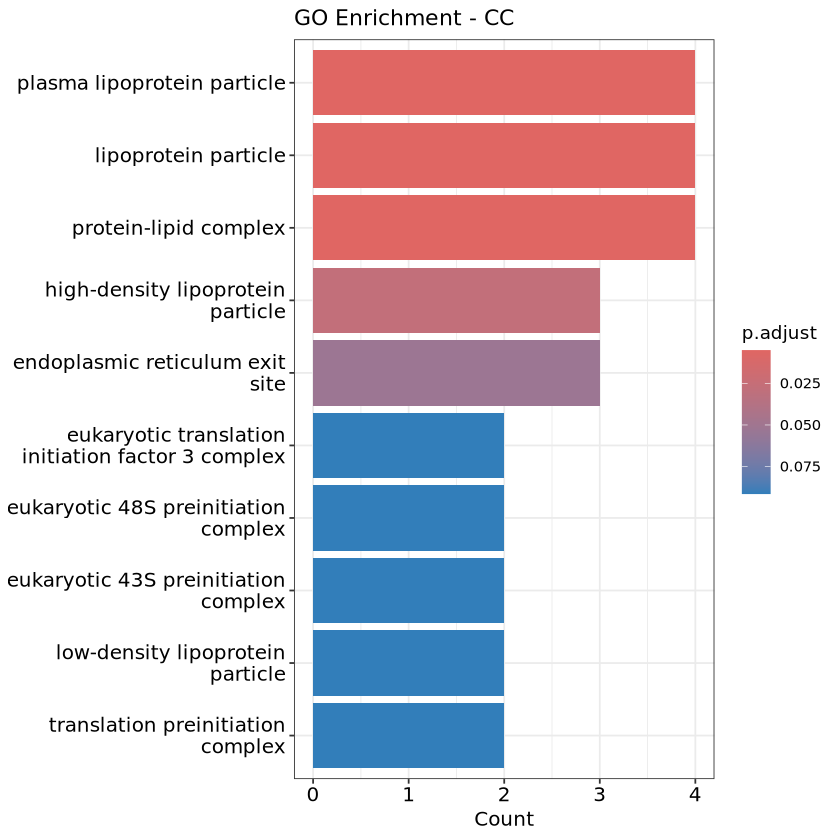

In [57]:
barplot(Aging1_xQTL_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [134]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging1_GO_CC.png', width = 6, height = 6)

In [58]:
Aging1_xQTL_ego_mf <- enrichGO(
  gene          = unique_genes$unique_Aging1_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [59]:
head(Aging1_xQTL_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004062,GO:0004062,aryl sulfotransferase activity,2/102,10/21059,0.001019239,0.1063120,0.09808101,ENSG00000196502/ENSG00000197165,2
GO:0015081,GO:0015081,sodium ion transmembrane transporter activity,5/102,164/21059,0.001221979,0.1063120,0.09808101,ENSG00000158865/ENSG00000135740/ENSG00000168575/ENSG00000066230/ENSG00000088836,5
GO:0008135,GO:0008135,"translation factor activity, RNA binding",4/102,97/21059,0.001272853,0.1063120,0.09808101,ENSG00000178952/ENSG00000205609/ENSG00000184110/ENSG00000119718,4
GO:0022853,GO:0022853,active monoatomic ion transmembrane transporter activity,6/102,262/21059,0.001741336,0.1063120,0.09808101,ENSG00000131055/ENSG00000158865/ENSG00000196296/ENSG00000135740/ENSG00000168575/ENSG00000066230,6
GO:0003743,GO:0003743,translation initiation factor activity,3/102,52/21059,0.002052356,0.1063120,0.09808101,ENSG00000205609/ENSG00000184110/ENSG00000119718,3
GO:0015386,GO:0015386,potassium:proton antiporter activity,2/102,16/21059,0.002666940,0.1093940,0.10092433,ENSG00000135740/ENSG00000066230,2
GO:0090079,GO:0090079,"translation regulator activity, nucleic acid binding",4/102,123/21059,0.003030718,0.1093940,0.10092433,ENSG00000178952/ENSG00000205609/ENSG00000184110/ENSG00000119718,4
GO:0015385,GO:0015385,sodium:proton antiporter activity,2/102,18/21059,0.003378964,0.1093940,0.10092433,ENSG00000135740/ENSG00000066230,2
GO:0022821,GO:0022821,solute:potassium antiporter activity,2/102,21/21059,0.004594154,0.1322096,0.12197345,ENSG00000135740/ENSG00000066230,2


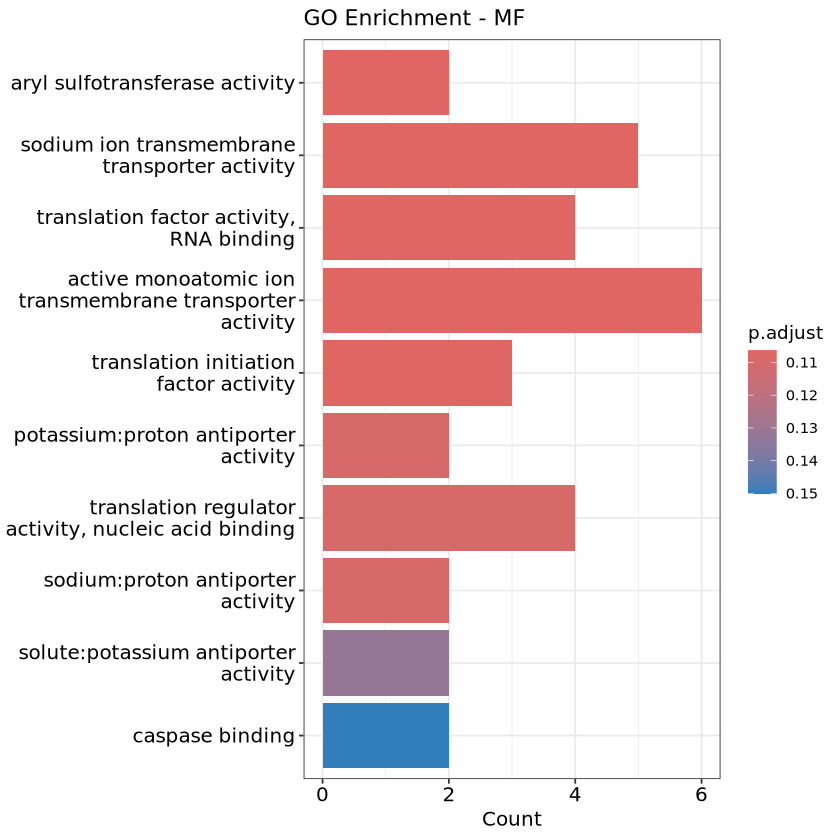

In [60]:
barplot(Aging1_xQTL_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [138]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging1_GO_MF.png', width = 6, height = 6)

### image_Aging2_xQTL list

In [61]:
Aging2_xQTL_ego <- enrichGO(
  gene          = unique_genes$unique_Aging2_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [62]:
head(Aging2_xQTL_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000724,GO:0000724,double-strand break repair via homologous recombination,4/42,182/21261,0.0004510170,0.1056199,0.09301409,ENSG00000181625/ENSG00000149923/ENSG00000106399/ENSG00000108384,4
GO:0000723,GO:0000723,telomere maintenance,4/42,185/21261,0.0004797031,0.1056199,0.09301409,ENSG00000169592/ENSG00000181625/ENSG00000106399/ENSG00000108384,4
GO:0000725,GO:0000725,recombinational repair,4/42,186/21261,0.0004895478,0.1056199,0.09301409,ENSG00000181625/ENSG00000149923/ENSG00000106399/ENSG00000108384,4
GO:0043433,GO:0043433,negative regulation of DNA-binding transcription factor activity,4/42,186/21261,0.0004895478,0.1056199,0.09301409,ENSG00000149922/ENSG00000103490/ENSG00000185104/ENSG00000108395,4
GO:0006310,GO:0006310,DNA recombination,5/42,365/21261,0.0007323939,0.1264112,0.11132387,ENSG00000169592/ENSG00000181625/ENSG00000149923/ENSG00000106399/ENSG00000108384,5


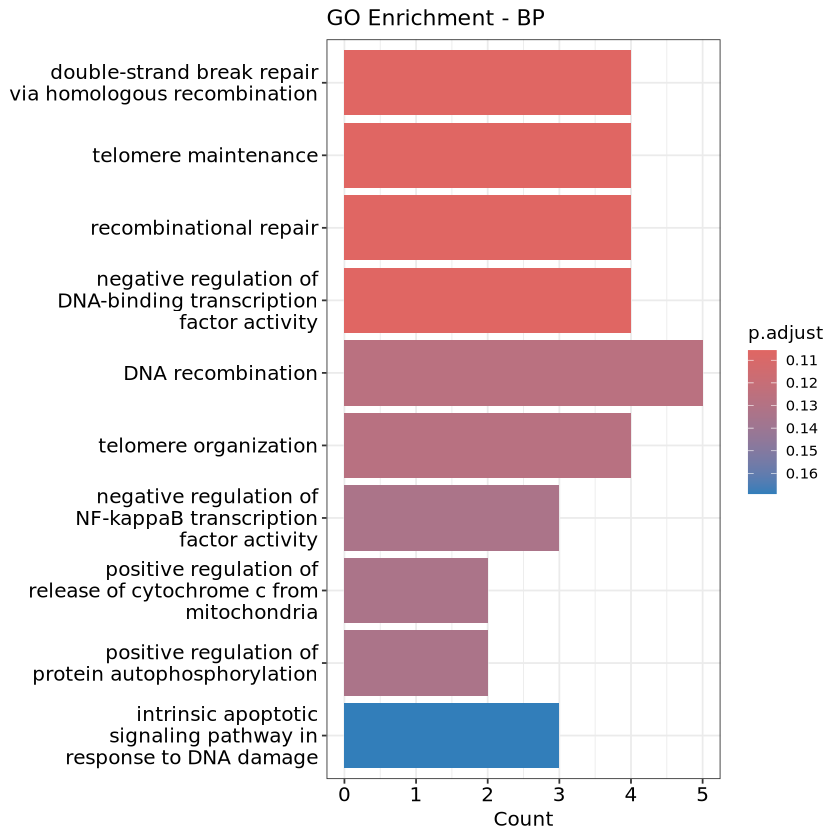

In [63]:
barplot(Aging2_xQTL_ego, showCategory = 10, title = "GO Enrichment - BP")

In [142]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging2_GO_BP.png', width = 6, height = 6)

In [64]:
Aging2_xQTL_ego_cc <- enrichGO(
  gene          = unique_genes$unique_Aging2_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [65]:
head(Aging2_xQTL_ego_cc, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005657,GO:0005657,replication fork,2/44,67/22568,0.007579365,0.1987291,0.1621799,ENSG00000106399/ENSG00000108384,2
GO:0098978,GO:0098978,glutamatergic synapse,4/44,440/22568,0.010460838,0.1987291,0.1621799,ENSG00000149927/ENSG00000124181/ENSG00000135905/ENSG00000110975,4
GO:0000228,GO:0000228,nuclear chromosome,3/44,245/22568,0.012063066,0.1987291,0.1621799,ENSG00000169592/ENSG00000181625/ENSG00000106399,3
GO:0098850,GO:0098850,extrinsic component of synaptic vesicle membrane,1/44,11/22568,0.021243110,0.1987291,0.1621799,ENSG00000149927,1
GO:0044294,GO:0044294,dendritic growth cone,1/44,12/22568,0.023152286,0.1987291,0.1621799,ENSG00000149930,1


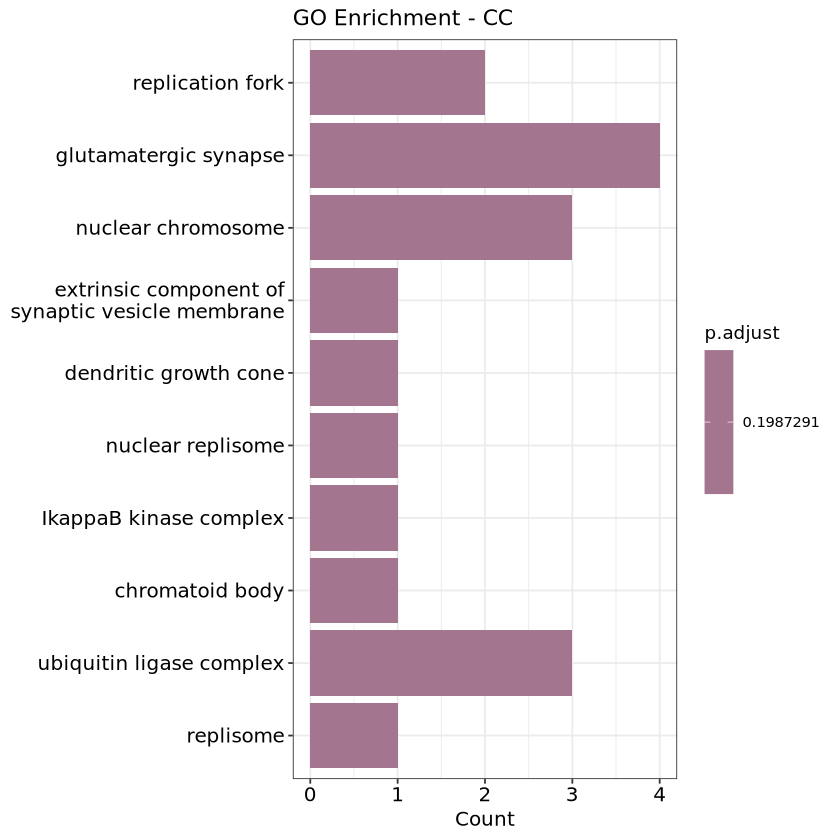

In [66]:
barplot(Aging2_xQTL_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [146]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging2_GO_CC.png', width = 6, height = 6)

In [67]:
Aging2_xQTL_ego_mf <- enrichGO(
  gene          = unique_genes$unique_Aging2_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [68]:
head(Aging2_xQTL_ego_mf, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016889,GO:0016889,"DNA endonuclease activity, producing 3'-phosphomonoesters",2/44,10/21059,0.0001899581,0.02963347,0.02339484,ENSG00000181625/ENSG00000108384,2
GO:0042578,GO:0042578,phosphoric ester hydrolase activity,5/44,390/21059,0.0012734899,0.05814522,0.04590412,ENSG00000107902/ENSG00000149923/ENSG00000175175/ENSG00000124181/ENSG00000108389,5
GO:0016894,GO:0016894,"endonuclease activity, active with either ribo- or deoxyribonucleic acids and producing 3'-phosphomonoesters",2/44,27/21059,0.0014486026,0.05814522,0.04590412,ENSG00000181625/ENSG00000108384,2
GO:0004722,GO:0004722,protein serine/threonine phosphatase activity,3/44,108/21059,0.0014909032,0.05814522,0.04590412,ENSG00000149923/ENSG00000175175/ENSG00000108389,3
GO:0016791,GO:0016791,phosphatase activity,4/44,292/21059,0.0031781977,0.09057058,0.07150309,ENSG00000107902/ENSG00000149923/ENSG00000175175/ENSG00000108389,4
GO:0004520,GO:0004520,DNA endonuclease activity,2/44,42/21059,0.0034834837,0.09057058,0.07150309,ENSG00000181625/ENSG00000108384,2
GO:0016504,GO:0016504,peptidase activator activity,2/44,56/21059,0.0061163306,0.12344230,0.09745444,ENSG00000103490/ENSG00000136560,2
GO:0005544,GO:0005544,calcium-dependent phospholipid binding,2/44,57/21059,0.0063303742,0.12344230,0.09745444,ENSG00000149927/ENSG00000110975,2
GO:0004721,GO:0004721,phosphoprotein phosphatase activity,3/44,192/21059,0.0075093506,0.12734954,0.10053911,ENSG00000149923/ENSG00000175175/ENSG00000108389,3


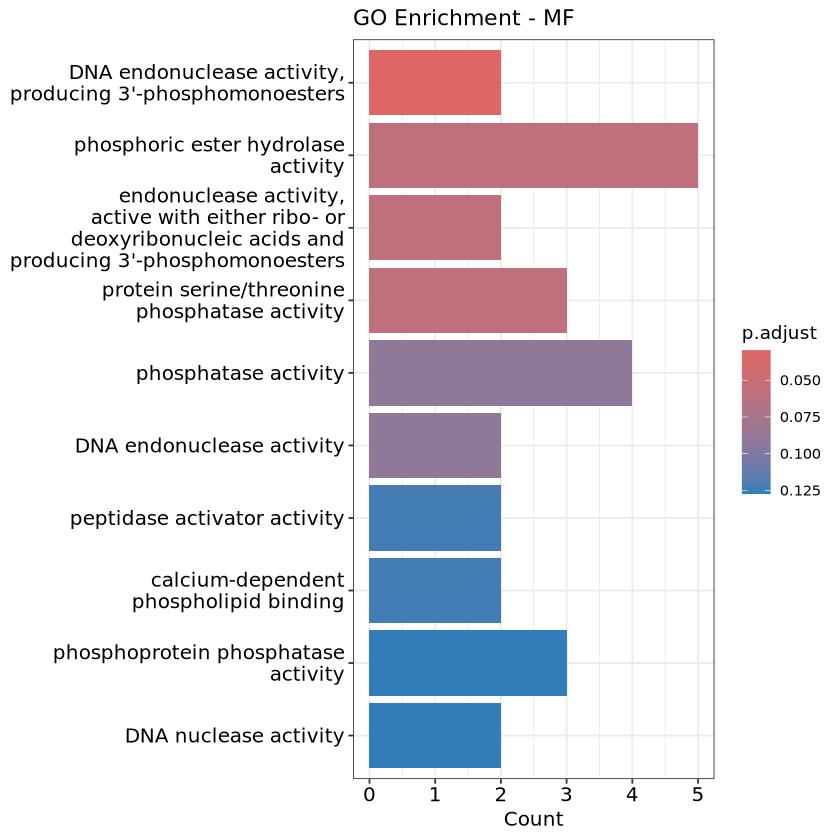

In [69]:
barplot(Aging2_xQTL_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [150]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging2_GO_MF.png', width = 6, height = 6)

### image_Aging3_xQTL list

In [70]:
Aging3_xQTL_ego <- enrichGO(
  gene          = unique_genes$unique_Aging3_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [71]:
head(Aging3_xQTL_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051647,GO:0051647,nucleus localization,3/28,33/21261,1.086892e-05,0.01299923,0.009084132,ENSG00000136717/ENSG00000070831/ENSG00000100242,3
GO:1903170,GO:1903170,negative regulation of calcium ion transmembrane transport,3/28,55/21261,5.125894e-05,0.01788608,0.012499164,ENSG00000136717/ENSG00000263715/ENSG00000120088,3
GO:0034763,GO:0034763,negative regulation of transmembrane transport,4/28,160/21261,5.493633e-05,0.01788608,0.012499164,ENSG00000136717/ENSG00000185950/ENSG00000263715/ENSG00000120088,4
GO:0035934,GO:0035934,corticosterone secretion,2/28,10/21261,7.477460e-05,0.01788608,0.012499164,ENSG00000263715/ENSG00000120088,2
GO:0051866,GO:0051866,general adaptation syndrome,2/28,10/21261,7.477460e-05,0.01788608,0.012499164,ENSG00000263715/ENSG00000120088,2
GO:0051458,GO:0051458,corticotropin secretion,2/28,11/21261,9.131670e-05,0.01820246,0.012720256,ENSG00000263715/ENSG00000120088,2
GO:0007565,GO:0007565,female pregnancy,4/28,198/21261,1.253989e-04,0.01893614,0.013232964,ENSG00000112715/ENSG00000142798/ENSG00000263715/ENSG00000120088,4
GO:2000849,GO:2000849,regulation of glucocorticoid secretion,2/28,14/21261,1.507186e-04,0.01893614,0.013232964,ENSG00000263715/ENSG00000120088,2
GO:0044703,GO:0044703,multi-organism reproductive process,4/28,224/21261,2.013565e-04,0.01893614,0.013232964,ENSG00000112715/ENSG00000142798/ENSG00000263715/ENSG00000120088,4


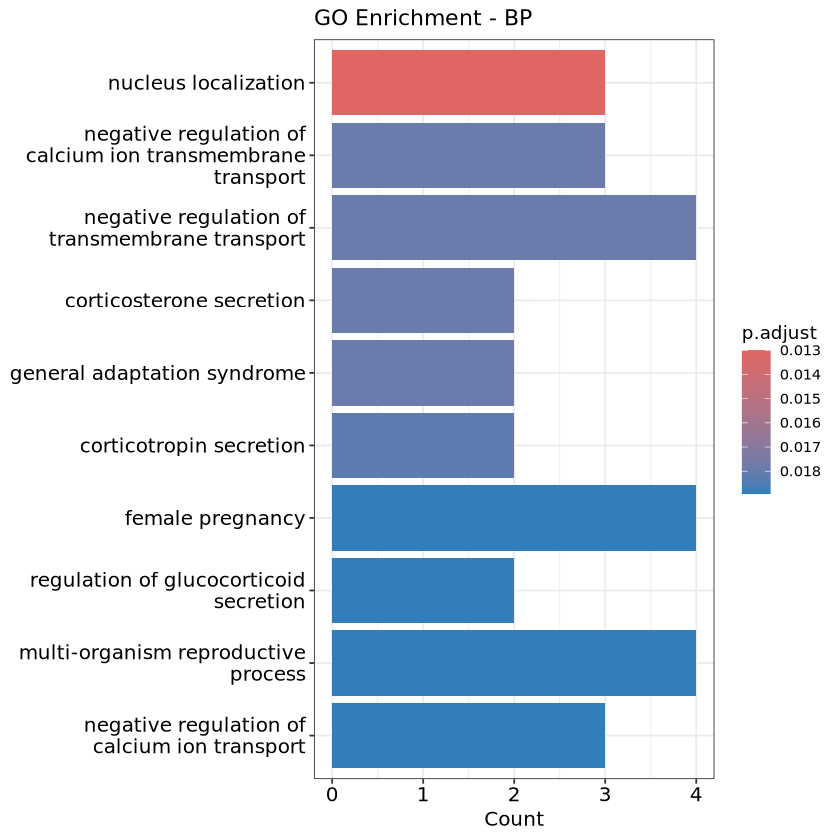

In [72]:
barplot(Aging3_xQTL_ego, showCategory = 10, title = "GO Enrichment - BP")

In [154]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging3_GO_BP.png', width = 6, height = 6)

In [73]:
Aging3_xQTL_ego_cc <- enrichGO(
  gene          = unique_genes$unique_Aging3_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [74]:
head(Aging3_xQTL_ego_cc, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044304,GO:0044304,main axon,2/28,81/22568,0.004526908,0.1408172,0.1134271,ENSG00000136717/ENSG00000186868,2
GO:0017119,GO:0017119,Golgi transport complex,1/28,10/22568,0.012340354,0.1408172,0.1134271,ENSG00000070831,1
GO:0034992,GO:0034992,microtubule organizing center attachment site,1/28,11/22568,0.013566282,0.1408172,0.1134271,ENSG00000100242,1
GO:0034993,GO:0034993,meiotic nuclear membrane microtubule tethering complex,1/28,11/22568,0.013566282,0.1408172,0.1134271,ENSG00000100242,1
GO:0098850,GO:0098850,extrinsic component of synaptic vesicle membrane,1/28,11/22568,0.013566282,0.1408172,0.1134271,ENSG00000136717,1


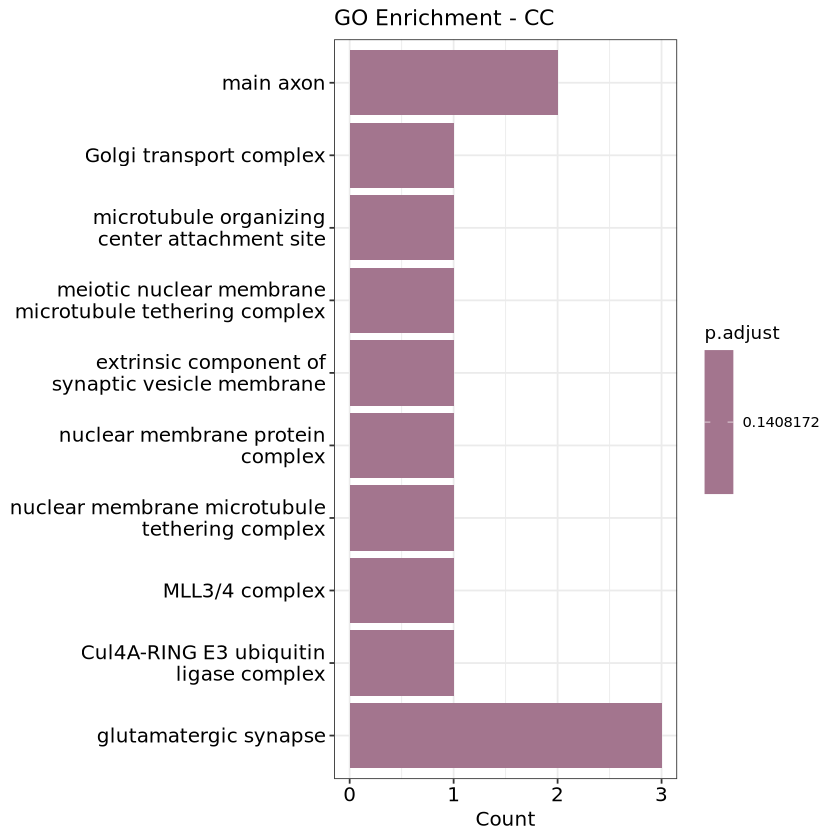

In [75]:
barplot(Aging3_xQTL_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [158]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging3_GO_CC.png', width = 6, height = 6)

PLEKHM1,MAP1LC3A, MAPT,STPBN1, CDC42,DOC2A,MAPK3,SPTBN1,MAP1LC3A are highly related with mitophagy.

In [76]:
Aging3_xQTL_ego_mf <- enrichGO(
  gene          = unique_genes$unique_Aging3_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [77]:
head(Aging3_xQTL_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0017046,GO:0017046,peptide hormone binding,2/28,55/21059,0.002423661,0.1132512,0.07222321,ENSG00000263715/ENSG00000120088,2
GO:0030674,GO:0030674,protein-macromolecule adaptor activity,4/28,459/21059,0.003012265,0.1132512,0.07222321,ENSG00000185950/ENSG00000186868/ENSG00000100991/ENSG00000100242,4
GO:0019902,GO:0019902,phosphatase binding,3/28,230/21059,0.003443432,0.1132512,0.07222321,ENSG00000185950/ENSG00000186868/ENSG00000100991,3
GO:0008017,GO:0008017,microtubule binding,3/28,289/21059,0.006500981,0.1132512,0.07222321,ENSG00000186868/ENSG00000101460/ENSG00000100242,3
GO:0042562,GO:0042562,hormone binding,2/28,92/21059,0.006627905,0.1132512,0.07222321,ENSG00000263715/ENSG00000120088,2
GO:0003713,GO:0003713,transcription coactivator activity,3/28,321/21059,0.008668881,0.1132512,0.07222321,ENSG00000198646/ENSG00000100201/ENSG00000160208,3
GO:0031996,GO:0031996,thioesterase binding,1/28,10/21059,0.013219515,0.1132512,0.07222321,ENSG00000070831,1
GO:0042500,GO:0042500,"aspartic endopeptidase activity, intramembrane cleaving",1/28,10/21059,0.013219515,0.1132512,0.07222321,ENSG00000185294,1
GO:1990763,GO:1990763,arrestin family protein binding,1/28,10/21059,0.013219515,0.1132512,0.07222321,ENSG00000078747,1


GTPase activity: CDC42,ARL17B, ARL17A, ATPBP1(Ubiquitination of ABCE1 by NOT4 in Response to Mitochondrial Damage Links Co-translational Quality Control to PINK1-Directed Mitophagy)

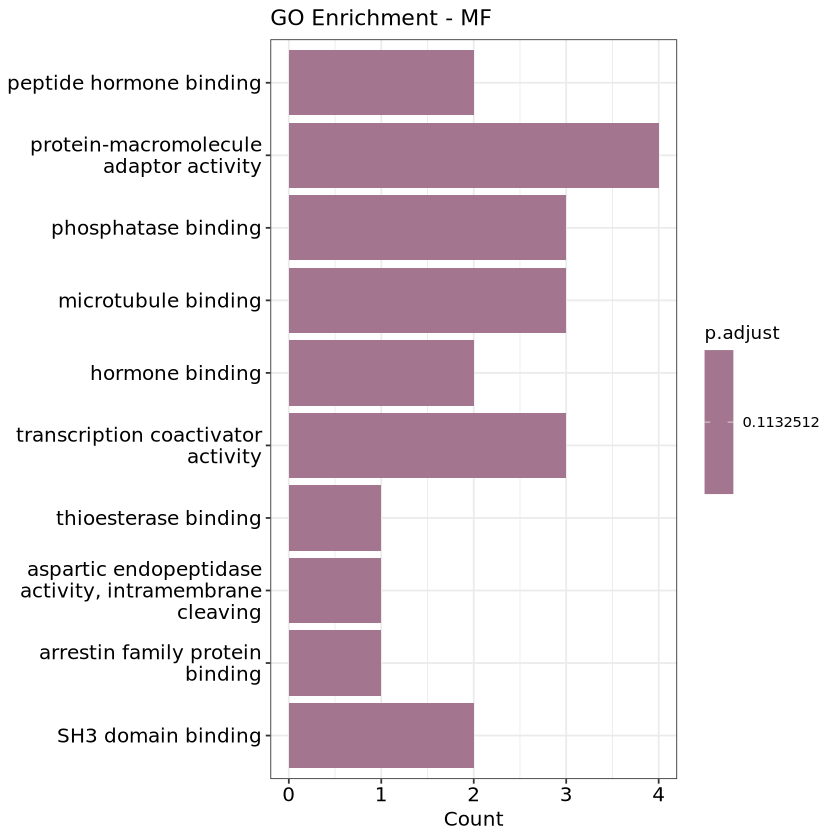

In [78]:
barplot(Aging3_xQTL_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [162]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging3_GO_MF.png', width = 6, height = 6)

### image_Aging4_xQTL list

In [79]:
Aging4_xQTL_ego <- enrichGO(
  gene          = unique_genes$unique_Aging4_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [80]:
head(Aging4_xQTL_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0032026,GO:0032026,response to magnesium ion,2/29,20/21261,0.0003361592,0.1342725,0.1092503,ENSG00000133065/ENSG00000153162,2
GO:0051222,GO:0051222,positive regulation of protein transport,4/29,340/21261,0.0011126814,0.1342725,0.1092503,ENSG00000117280/ENSG00000126262/ENSG00000153162/ENSG00000148737,4
GO:0050714,GO:0050714,positive regulation of protein secretion,3/29,157/21261,0.0012536377,0.1342725,0.1092503,ENSG00000126262/ENSG00000153162/ENSG00000148737,3
GO:0032350,GO:0032350,regulation of hormone metabolic process,2/29,40/21261,0.0013568845,0.1342725,0.1092503,ENSG00000153162/ENSG00000148737,2
GO:1904951,GO:1904951,positive regulation of establishment of protein localization,4/29,359/21261,0.0013598163,0.1342725,0.1092503,ENSG00000117280/ENSG00000126262/ENSG00000153162/ENSG00000148737,4


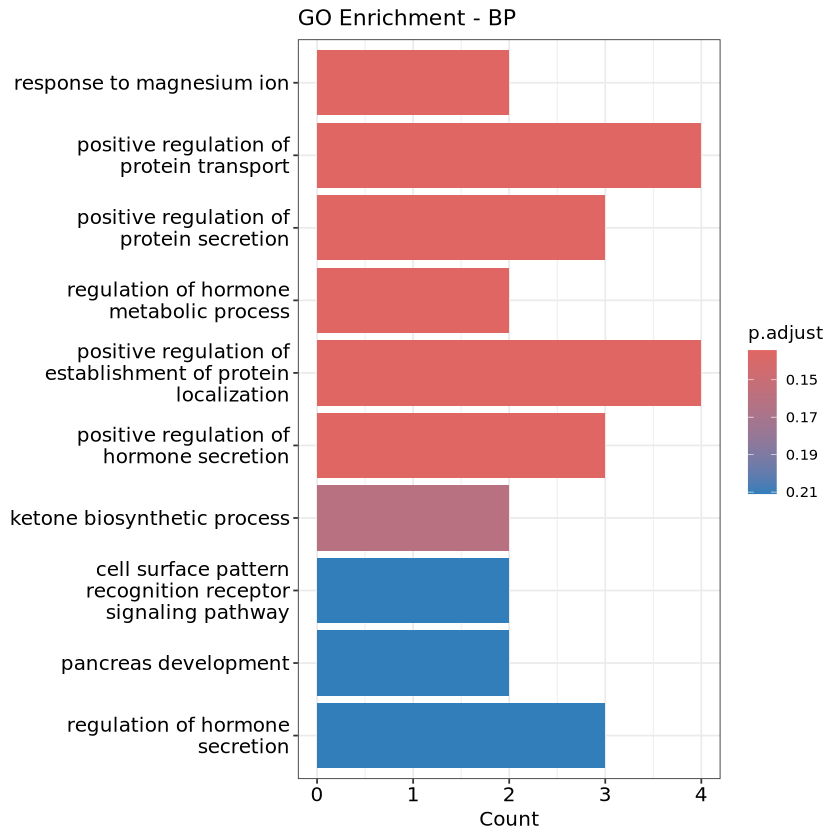

In [81]:
barplot(Aging4_xQTL_ego, showCategory = 10, title = "GO Enrichment - BP")

In [166]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging4_GO_BP.png', width = 6, height = 6)

In [82]:
Aging4_xQTL_ego_cc <- enrichGO(
  gene          = unique_genes$unique_Aging4_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [83]:
head(Aging4_xQTL_ego_cc, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0090575,GO:0090575,RNA polymerase II transcription regulator complex,3/32,281/22568,0.007254365,0.1455936,0.1221909,ENSG00000197780/ENSG00000196284/ENSG00000148737,3
GO:0016591,GO:0016591,"RNA polymerase II, holoenzyme",2/32,99/22568,0.008672903,0.1455936,0.1221909,ENSG00000197780/ENSG00000196284,2
GO:0055029,GO:0055029,nuclear DNA-directed RNA polymerase complex,2/32,131/22568,0.014801498,0.1455936,0.1221909,ENSG00000197780/ENSG00000196284,2
GO:0000428,GO:0000428,DNA-directed RNA polymerase complex,2/32,134/22568,0.015449137,0.1455936,0.1221909,ENSG00000197780/ENSG00000196284,2
GO:0030880,GO:0030880,RNA polymerase complex,2/32,138/22568,0.016331406,0.1455936,0.1221909,ENSG00000197780/ENSG00000196284,2


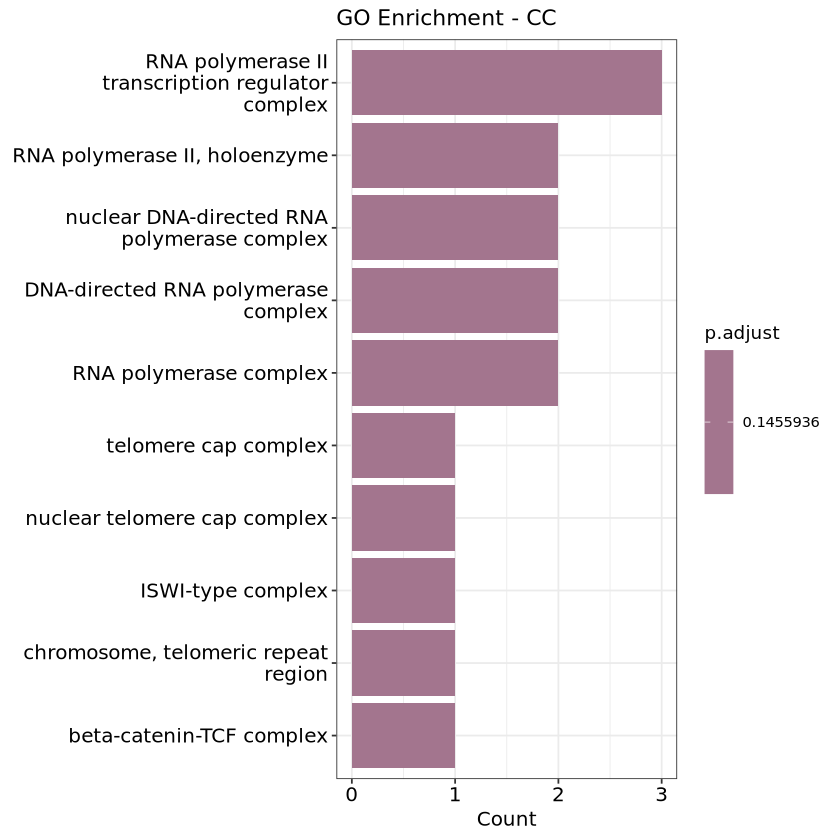

In [84]:
barplot(Aging4_xQTL_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [170]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging4_GO_CC.png', width = 6, height = 6)

In [85]:
Aging4_xQTL_ego_mf <- enrichGO(
  gene          = unique_genes$unique_Aging4_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [86]:
head(Aging4_xQTL_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015291,GO:0015291,secondary active transmembrane transporter activity,3/32,309/21059,0.01133020,0.1272671,0.08971996,ENSG00000174502/ENSG00000133065/ENSG00000180773,3
GO:0019531,GO:0019531,oxalate transmembrane transporter activity,1/32,10/21059,0.01509512,0.1272671,0.08971996,ENSG00000174502,1
GO:0045322,GO:0045322,unmethylated CpG binding,1/32,10/21059,0.01509512,0.1272671,0.08971996,ENSG00000272333,1
GO:0003924,GO:0003924,GTPase activity,3/32,353/21059,0.01616940,0.1272671,0.08971996,ENSG00000117280/ENSG00000276600/ENSG00000168827,3
GO:0015173,GO:0015173,aromatic amino acid transmembrane transporter activity,1/32,11/21059,0.01659244,0.1272671,0.08971996,ENSG00000180773,1
GO:0140999,GO:0140999,histone H3K4 trimethyltransferase activity,1/32,11/21059,0.01659244,0.1272671,0.08971996,ENSG00000272333,1
GO:0046982,GO:0046982,protein heterodimerization activity,3/32,360/21059,0.01703128,0.1272671,0.08971996,ENSG00000197780/ENSG00000153162/ENSG00000196284,3
GO:0043047,GO:0043047,single-stranded telomeric DNA binding,1/32,12/21059,0.01808754,0.1272671,0.08971996,ENSG00000107960,1
GO:0070700,GO:0070700,BMP receptor binding,1/32,12/21059,0.01808754,0.1272671,0.08971996,ENSG00000153162,1


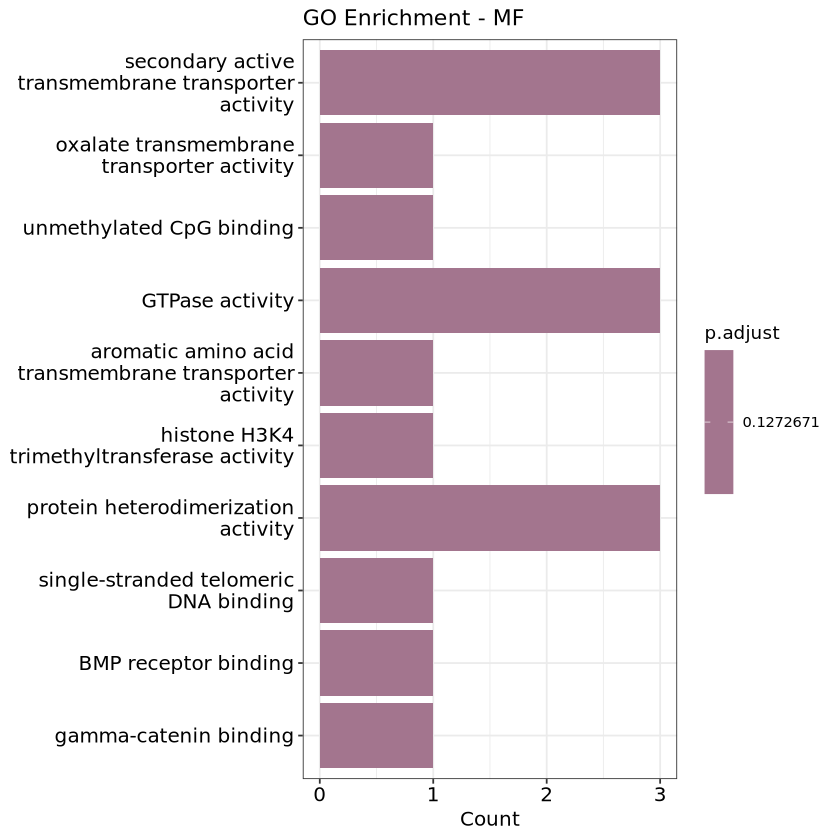

In [87]:
barplot(Aging4_xQTL_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [174]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging4_GO_MF.png', width = 6, height = 6)

### image_Aging5_xQTL list

In [88]:
Aging5_xQTL_ego <- enrichGO(
  gene          = unique_genes$unique_Aging5_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [89]:
head(Aging5_xQTL_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007044,GO:0007044,cell-substrate junction assembly,5/109,104/21261,0.0001984536,0.2040853,0.1961038,ENSG00000065618/ENSG00000198728/ENSG00000169756/ENSG00000044524/ENSG00000035403,5
GO:0150115,GO:0150115,cell-substrate junction organization,5/109,111/21261,0.0002688445,0.2040853,0.1961038,ENSG00000065618/ENSG00000198728/ENSG00000169756/ENSG00000044524/ENSG00000035403,5
GO:0051893,GO:0051893,regulation of focal adhesion assembly,4/109,70/21261,0.0004619927,0.2040853,0.1961038,ENSG00000198728/ENSG00000169756/ENSG00000044524/ENSG00000035403,4
GO:0090109,GO:0090109,regulation of cell-substrate junction assembly,4/109,70/21261,0.0004619927,0.2040853,0.1961038,ENSG00000198728/ENSG00000169756/ENSG00000044524/ENSG00000035403,4
GO:0150116,GO:0150116,regulation of cell-substrate junction organization,4/109,75/21261,0.0006005263,0.2122260,0.2039261,ENSG00000198728/ENSG00000169756/ENSG00000044524/ENSG00000035403,4


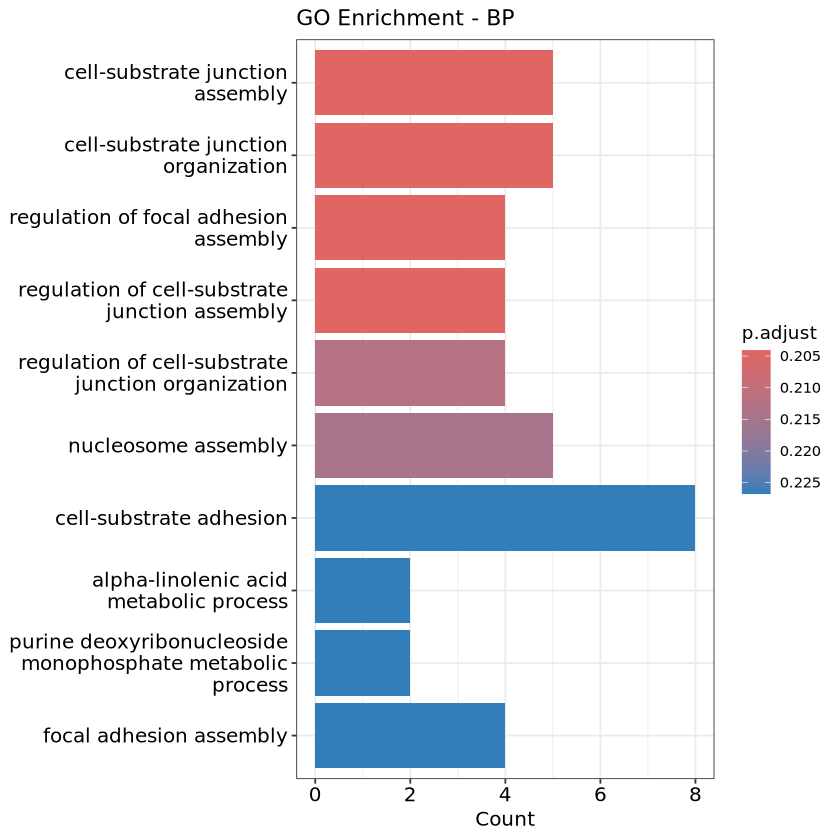

In [90]:
barplot(Aging5_xQTL_ego, showCategory = 10, title = "GO Enrichment - BP")

In [178]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging5_GO_BP.png', width = 6, height = 6)

In [91]:
Aging5_xQTL_ego_cc <- enrichGO(
  gene          = unique_genes$unique_Aging5_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [92]:
head(Aging5_xQTL_ego_cc, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0045178,GO:0045178,basal part of cell,7/114,330/22568,0.001451703,0.1960257,0.1936169,ENSG00000148842/ENSG00000185933/ENSG00000010704/ENSG00000137312/ENSG00000133059/ENSG00000204217/ENSG00000197405,7
GO:0043505,GO:0043505,CENP-A containing nucleosome,2/114,18/22568,0.003670659,0.1960257,0.1936169,ENSG00000273542/ENSG00000197061,2
GO:0061638,GO:0061638,CENP-A containing chromatin,2/114,18/22568,0.003670659,0.1960257,0.1936169,ENSG00000273542/ENSG00000197061,2
GO:0034506,GO:0034506,"chromosome, centromeric core domain",2/114,20/22568,0.004528410,0.1960257,0.1936169,ENSG00000273542/ENSG00000197061,2
GO:0009925,GO:0009925,basal plasma membrane,6/114,311/22568,0.005021810,0.1960257,0.1936169,ENSG00000148842/ENSG00000185933/ENSG00000137312/ENSG00000133059/ENSG00000204217/ENSG00000197405,6


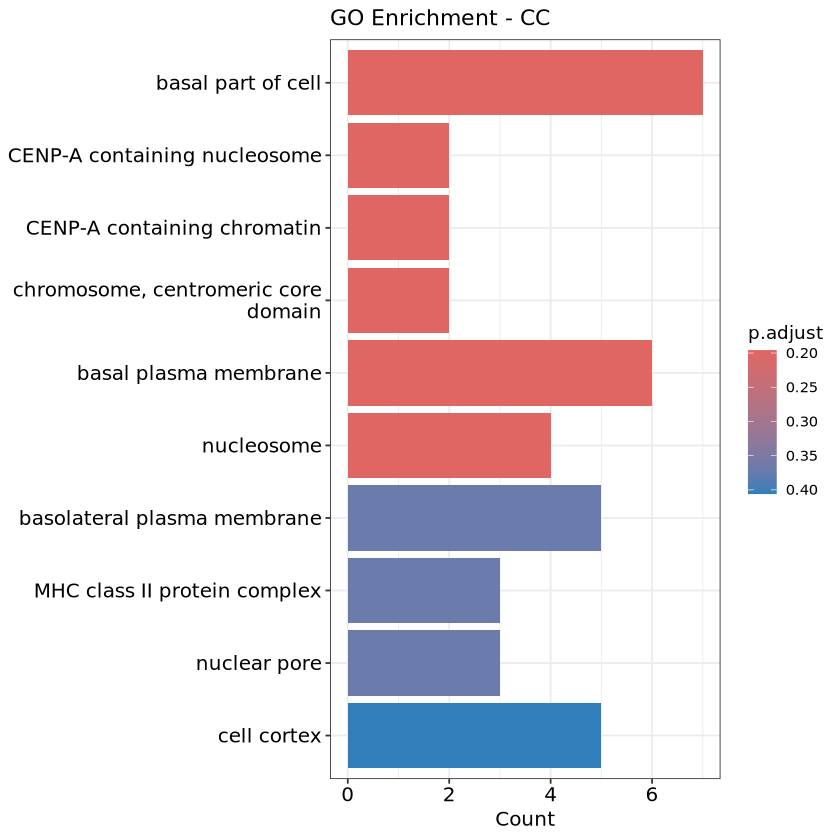

In [93]:
barplot(Aging5_xQTL_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [182]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging5_GO_CC.png', width = 6, height = 6)

In [94]:
Aging5_xQTL_ego_mf <- enrichGO(
  gene          = unique_genes$unique_Aging5_genes,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [95]:
head(Aging5_xQTL_ego_mf, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016717,GO:0016717,"oxidoreductase activity, acting on paired donors, with oxidation of a pair of donors resulting in the reduction of molecular oxygen to two molecules of water",2/115,10/21059,0.001292785,0.1936745,0.1930061,ENSG00000134824/ENSG00000149485,2
GO:0030527,GO:0030527,structural constituent of chromatin,4/115,101/21059,0.002293104,0.1936745,0.1930061,ENSG00000233822/ENSG00000273542/ENSG00000286522/ENSG00000197061,4
GO:0004879,GO:0004879,nuclear receptor activity,3/115,57/21059,0.003745773,0.1936745,0.1930061,ENSG00000204231/ENSG00000177463/ENSG00000077092,3
GO:0098531,GO:0098531,ligand-activated transcription factor activity,3/115,57/21059,0.003745773,0.1936745,0.1930061,ENSG00000204231/ENSG00000177463/ENSG00000077092,3
GO:0061659,GO:0061659,ubiquitin-like protein ligase activity,8/115,464/21059,0.003968740,0.1936745,0.1930061,ENSG00000107954/ENSG00000204308/ENSG00000166167/ENSG00000076685/ENSG00000112343/ENSG00000153201/ENSG00000204616/ENSG00000014123,8


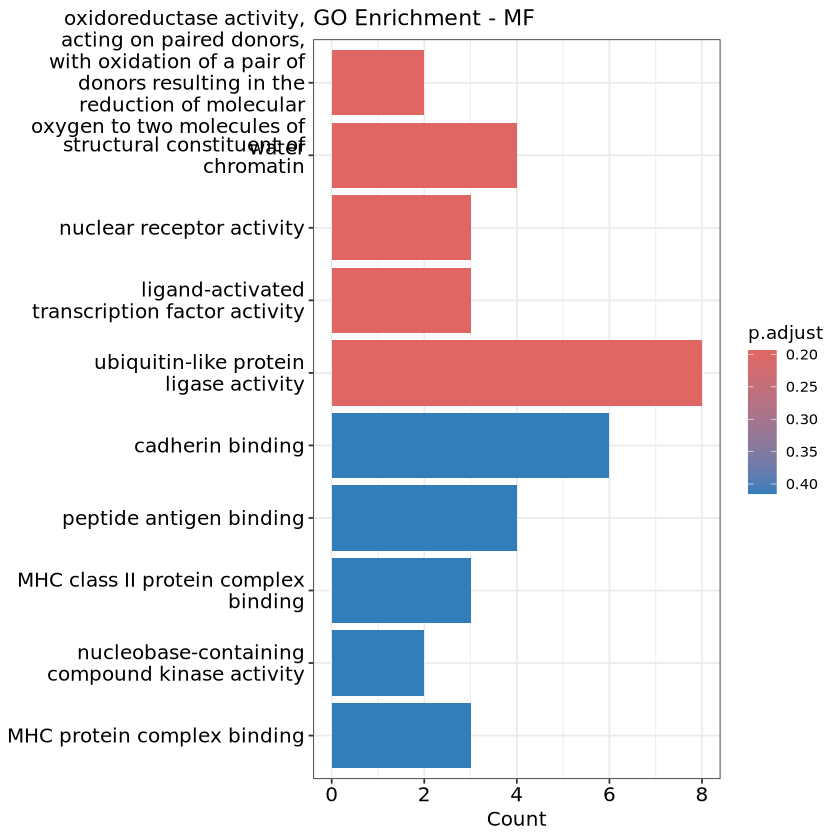

In [96]:
barplot(Aging5_xQTL_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [186]:
ggsave('~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/figs/image_Aging5_GO_MF.png', width = 6, height = 6)